## Clone GitHub Repo

In [1]:
!git clone https://github.com/bhargav-borah/CIFAR10ImageClassification

Cloning into 'CIFAR10ImageClassification'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 83 (delta 9), reused 0 (delta 0), pack-reused 57
Unpacking objects: 100% (83/83), 1.34 MiB | 4.36 MiB/s, done.


## Import the dependencies

In [20]:
!pip install torchinfo

In [21]:
import torch
from torch import nn
import torchvision
from torchvision.transforms import transforms
from torchinfo import summary

import os
from accuracy import accuracy_fn

## Set up device-agnostic code

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Create train and test dataloaders

In [9]:
from data_setup import get_cifar10_dataloaders

In [10]:
data_dir = 'data'

In [16]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
transforms = weights.transforms()
transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [17]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader, test_dataloader, class_names = get_cifar10_dataloaders(data_dir=data_dir,
                                                                         transform=transforms,
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS)

Files already downloaded and verified
Files already downloaded and verified


In [19]:
model_7 = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 54.5MB/s]


In [23]:
for param in model_7.parameters():
    param.requires_grad = False

In [24]:
summary(model=model_7, 
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   False
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16

In [25]:
model_7.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [28]:
model_7.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

In [27]:
summary(model=model_7, 
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_7.parameters(), 
                             lr=1e-3)

In [32]:
from model_builder import fit

In [33]:
history_7 = fit(model=model_7,
                epochs=10,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn, 
                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Training loss:  0.8726861476898193 | Training accuracy: 0.720209538936615 | Test loss: 0.6052255034446716 | Test accuracy: 0.7961261868476868
Training loss:  0.713628888130188 | Training accuracy: 0.7579774260520935 | Test loss: 0.5806143283843994 | Test accuracy: 0.7999201416969299
Training loss:  0.6900055408477783 | Training accuracy: 0.7675943970680237 | Test loss: 0.5586150288581848 | Test accuracy: 0.8084065318107605
Training loss:  0.6913194060325623 | Training accuracy: 0.7645353674888611 | Test loss: 0.574389636516571 | Test accuracy: 0.8041133880615234
Training loss:  0.6843294501304626 | Training accuracy: 0.767174482345581 | Test loss: 0.5593820214271545 | Test accuracy: 0.8058106899261475
Training loss:  0.6732181906700134 | Training accuracy: 0.7685340642929077 | Test loss: 0.5493040084838867 | Test accuracy: 0.8096046447753906
Training loss:  0.6721379160881042 | Training accuracy: 0.7706333994865417 | Test loss: 0.5585698485374451 | Test accuracy: 0.8083066940307617
Tra

In [34]:
from graphing import plot_loss_curves, plot_accuracy_curves

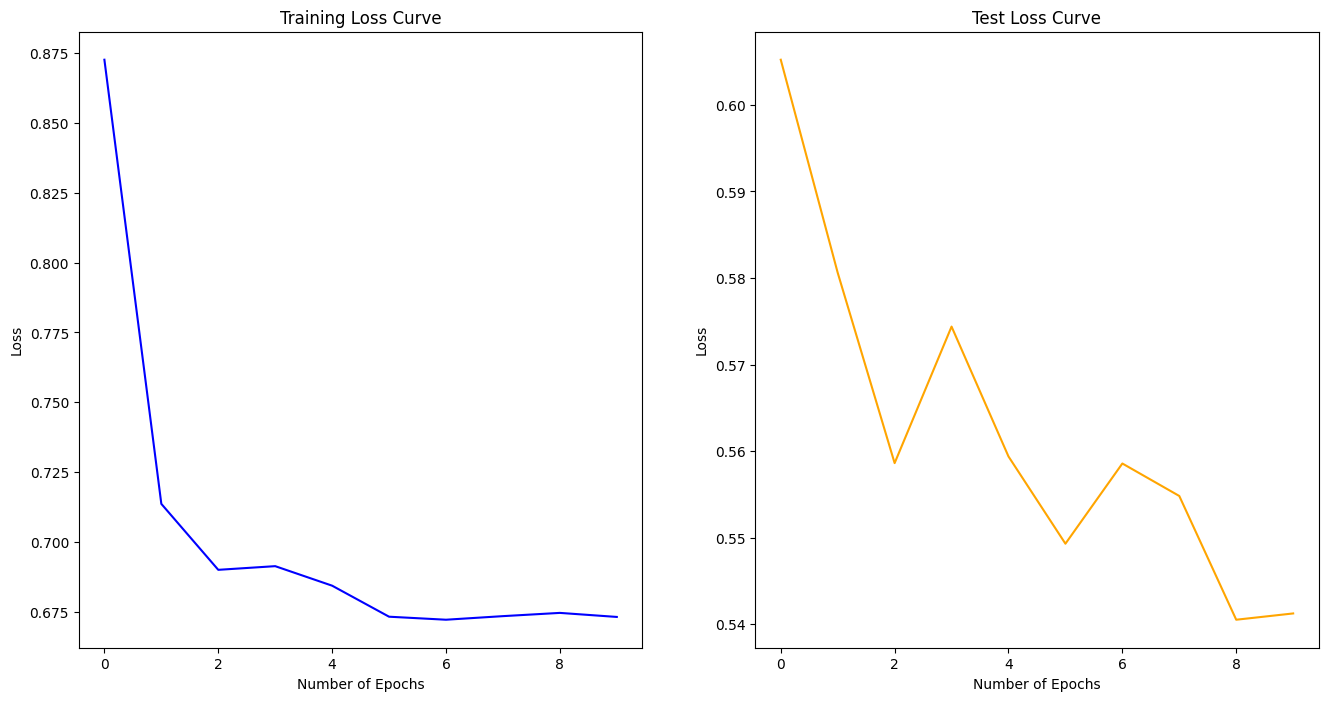

In [35]:
plot_loss_curves(train_losses=history_7['train_losses'],
                 test_losses=history_7['test_losses'])

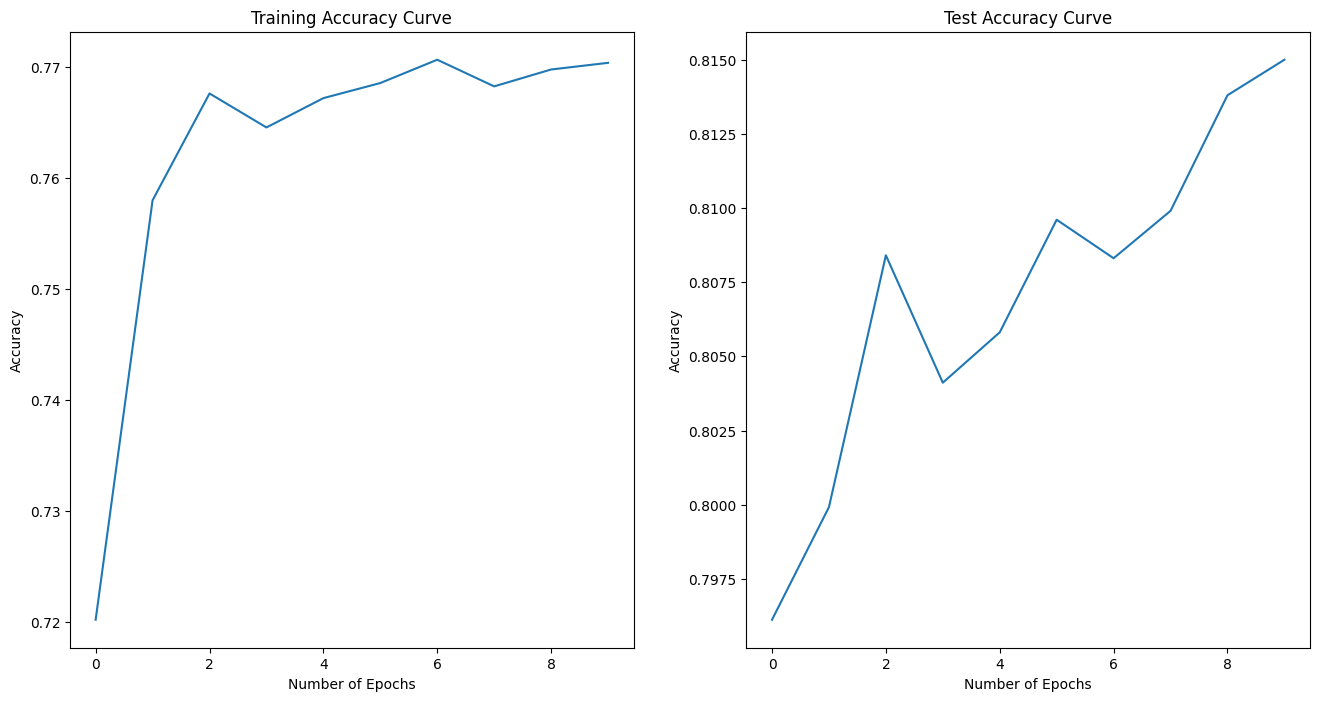

In [36]:
plot_accuracy_curves(train_accuracies=history_7['train_accuracies'],
                     test_accuracies=history_7['test_accuracies'])